In [100]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import scanpy as sc
import scipy

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14
pd.set_option('display.latex.escape', True)

sc.settings.verbosity = 3

In [101]:
covid_pbmc = sc.datasets.ebi_expression_atlas('E-MTAB-9221')

In [102]:
biots = sc.queries.biomart_annotations(host='www.ensembl.org', org='hsapiens',
                                       attrs=['ensembl_gene_id', 'gene_biotype',
                                              'external_gene_name'])

In [103]:
biots.dropna(subset=['ensembl_gene_id'], inplace=True)

In [104]:
biots = biots.set_index('ensembl_gene_id')

In [105]:
covid_pbmc.var = covid_pbmc.var.join(biots)

In [106]:
covid_pbmc.var['riboprots'] = covid_pbmc.var.external_gene_name.fillna(''
                                ).astype(str).str.contains('RPL\d|RPS\d+$')

In [107]:
covid_pbmc.obs['total_counts'] = covid_pbmc.X.sum(1)
covid_pbmc.obs['log_counts'] = np.log10(covid_pbmc.obs.total_counts)
covid_pbmc.var.external_gene_name = covid_pbmc.var.external_gene_name.fillna(
                                    pd.Series(covid_pbmc.var.index.values))

In [114]:
sc.pp.filter_cells(covid_pbmc, min_genes=1500)
sc.pp.filter_genes(covid_pbmc, min_cells=30)

filtered out 1710 cells that have less than 1500 genes expressed
filtered out 312 genes that are detected in less than 30 cells


In [115]:
sc.pp.calculate_qc_metrics(covid_pbmc, qc_vars=['riboprots'],
                               percent_top=None, log1p=False,
                               inplace=True)

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


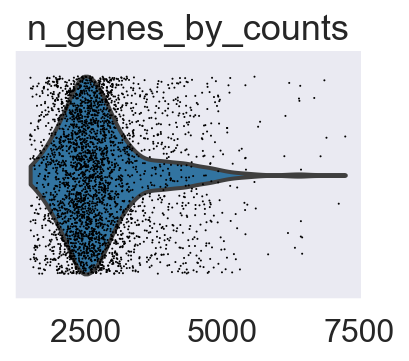

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


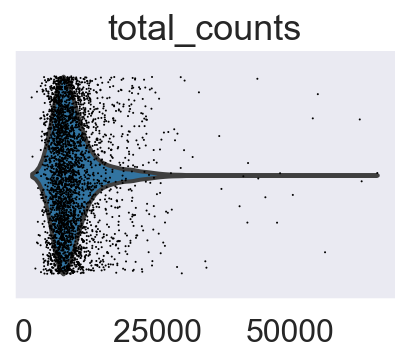

In [116]:
sc.pl.violin(covid_pbmc, ['n_genes_by_counts'], jitter=0.4, multi_panel=True)
sc.pl.violin(covid_pbmc, ['total_counts'], jitter=0.4, multi_panel=True)

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/seaborn/_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


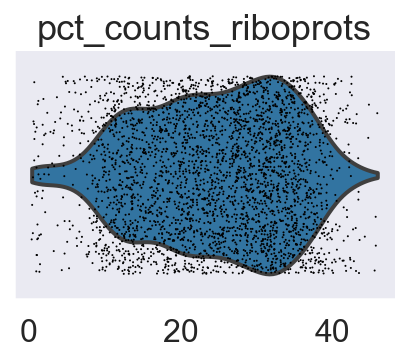

In [117]:
sc.pl.violin(covid_pbmc, ['pct_counts_riboprots'], jitter=0.4, multi_panel=True)

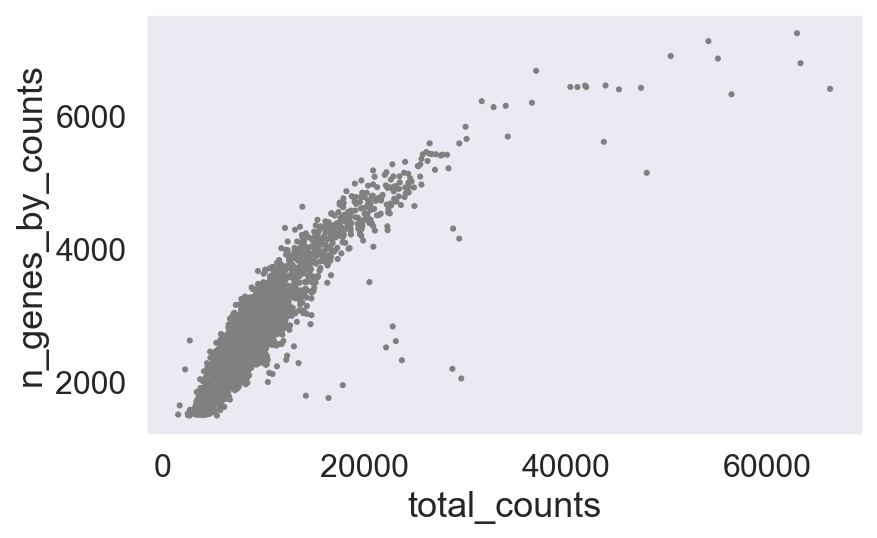

In [118]:
sc.pl.scatter(covid_pbmc, x='total_counts', y='n_genes_by_counts')

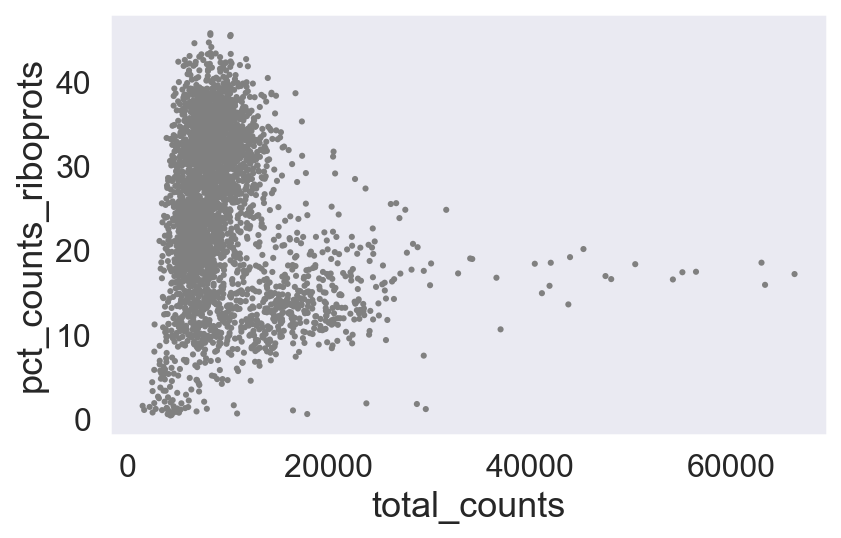

In [119]:
sc.pl.scatter(covid_pbmc, x='total_counts', y='pct_counts_riboprots')

In [122]:
covid_pbmc = covid_pbmc[covid_pbmc.obs.pct_counts_riboprots.between(10, 40), :]

In [123]:
covid_pbmc

View of AnnData object with n_obs × n_vars = 2907 × 13780
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[clinical history]', 'Sample Characteristic Ontology Term[clinical history]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Factor Value[disease]', 'Factor Value Ontology Term[disease]', 'Factor Value[clinical history]', 'Factor Value Ontology Term[clinical history]', 'Factor Value[sampling time point]', 'Factor Value Ontology Term[sampling time point]

In [125]:
sc.pp.normalize_per_cell(covid_pbmc, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [126]:
sc.pp.log1p(covid_pbmc)

In [127]:
covid_pbmc.raw = covid_pbmc

In [129]:
sc.pp.highly_variable_genes(covid_pbmc, flavor='cell_ranger', n_top_genes=4000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [131]:
sc.pp.regress_out(covid_pbmc, ['total_counts'], n_jobs=8)

regressing out ['total_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


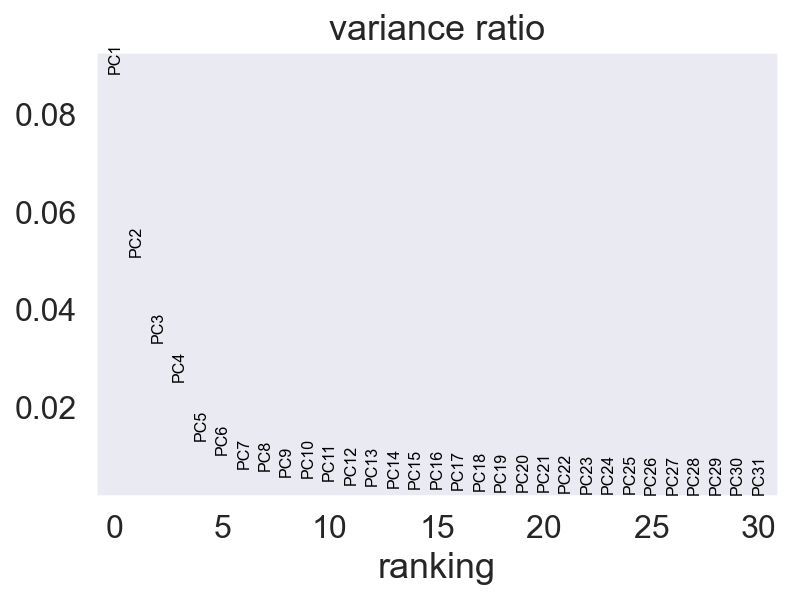

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [132]:
sc.pp.pca(covid_pbmc, n_comps=50, use_highly_variable=True,
          svd_solver='arpack')
sc.pl.pca_variance_ratio(covid_pbmc)
sc.pp.neighbors(covid_pbmc)

In [134]:
sc.tl.umap(covid_pbmc)
sc.tl.tsne(covid_pbmc, n_jobs=12)
sc.tl.diffmap(covid_pbmc)
sc.tl.draw_graph(covid_pbmc)
sc.tl.leiden(covid_pbmc, resolution=.5)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:16)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9978455  0.9976041  0.9869664  0.9834931  0.98306817
     0.9818656  0.9772071  0.97390795 0.96672446 0.96186745 0.95942456
     0.95786625 0.9569783  0.9553054 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:12)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


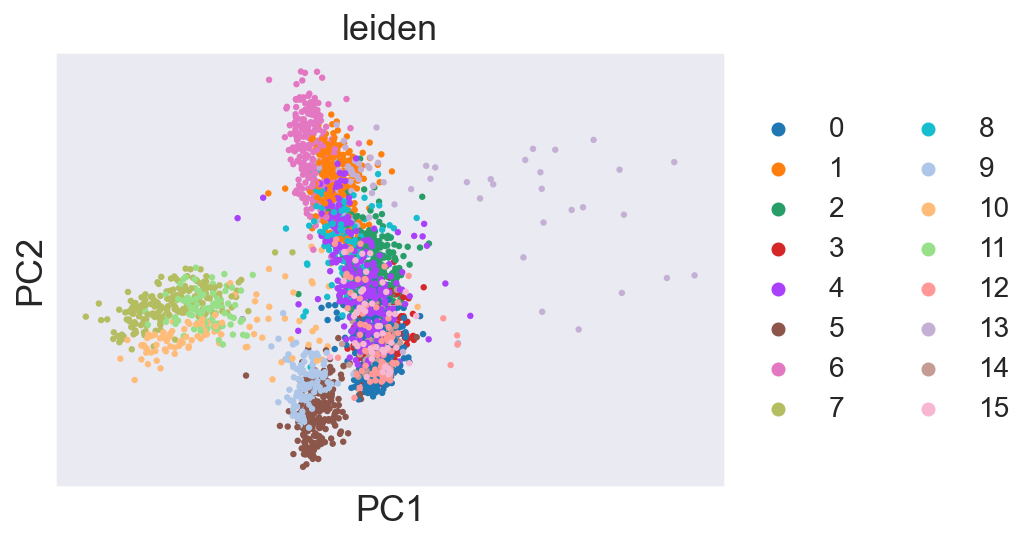

In [136]:
sc.pl.pca_scatter(covid_pbmc, color='leiden')

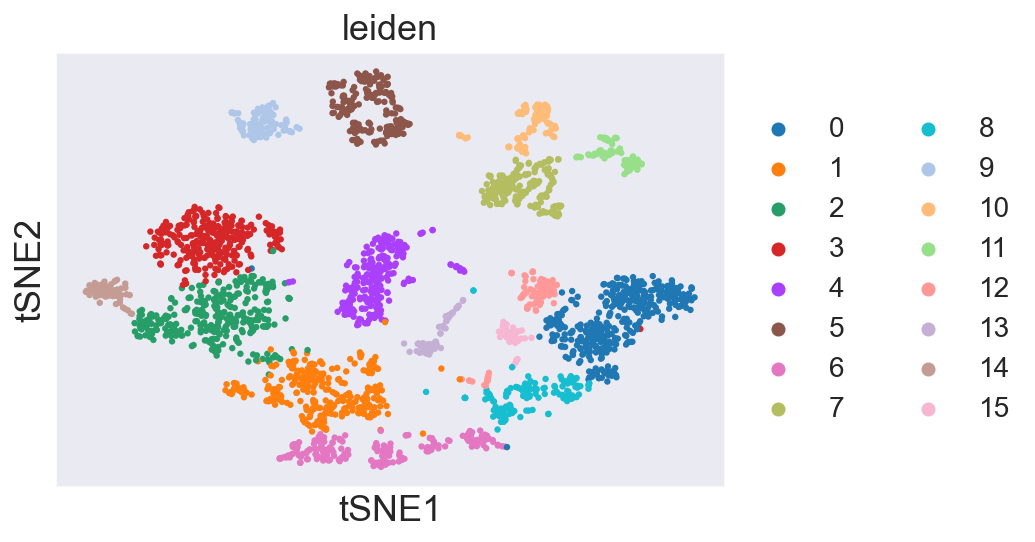

In [137]:
sc.pl.tsne(covid_pbmc, color='leiden')

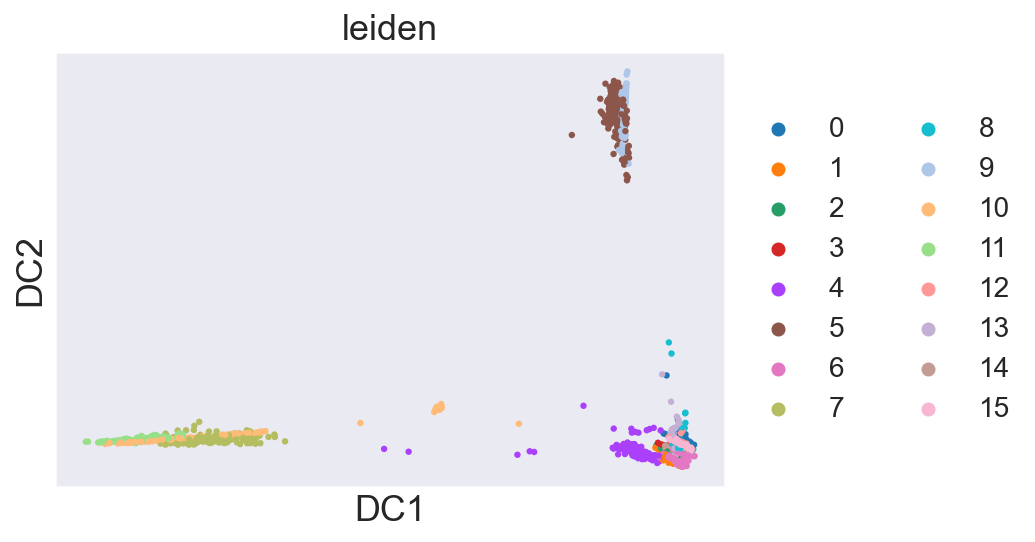

In [138]:
sc.pl.diffmap(covid_pbmc, color='leiden')

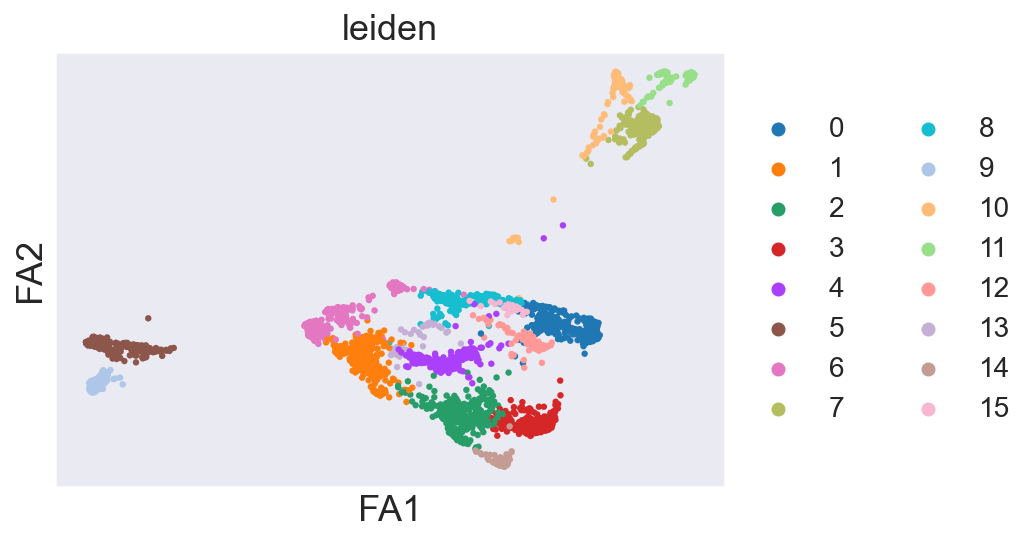

In [139]:
sc.pl.draw_graph(covid_pbmc, color='leiden')

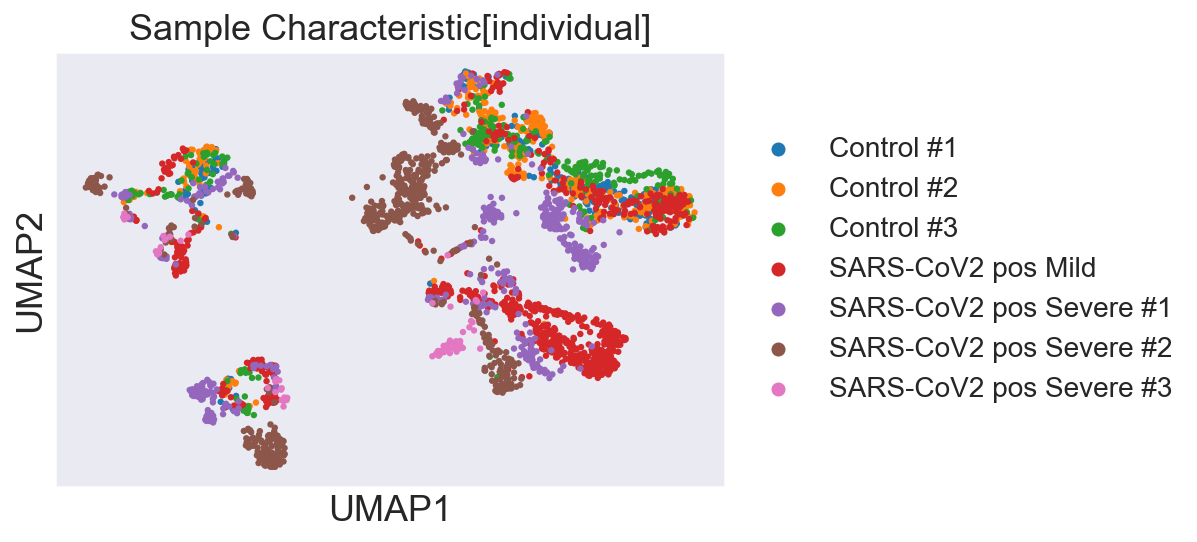

In [143]:
sc.pl.umap(covid_pbmc, color='Sample Characteristic[individual]')

In [146]:
covid_pbmc.obs['Characteristic'] = covid_pbmc.obs['Sample Characteristic[individual]'].str.split('#', expand=True)[0]

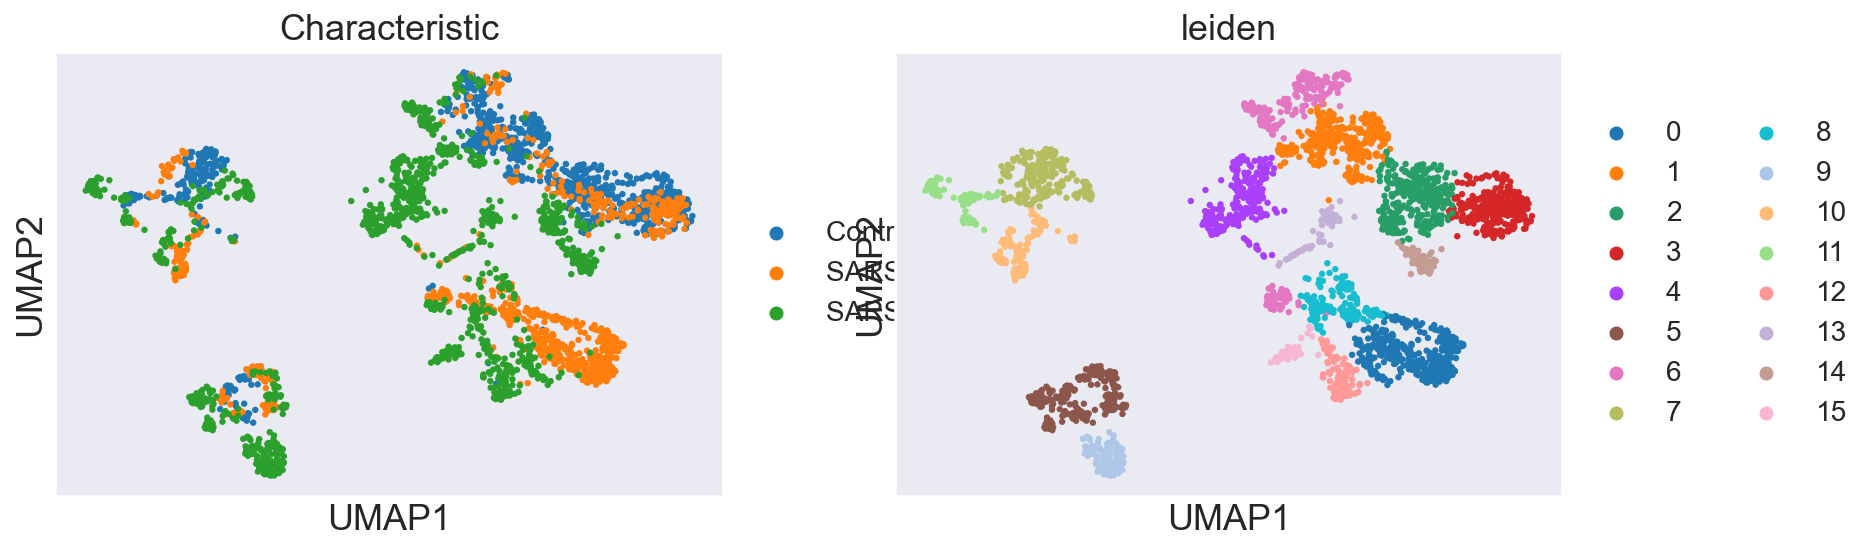

In [156]:
sc.pl.umap(covid_pbmc, color=[ 'Characteristic', 'leiden'])

In [157]:
sc.external.pp.bbknn(covid_pbmc, batch_key='Sample Characteristic[individual]')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [158]:
sc.tl.umap(covid_pbmc)
sc.tl.tsne(covid_pbmc, n_jobs=12)
sc.tl.diffmap(covid_pbmc)
sc.tl.draw_graph(covid_pbmc)
sc.tl.leiden(covid_pbmc, resolution=.5)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:17)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9917464  0.98498297 0.9764208  0.94623166 0.9392781
     0.8897525  0.88293123 0.8824573  0.86183006 0.85480046 0.8459173
     0.8248622  0.82135177 0.81641537]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


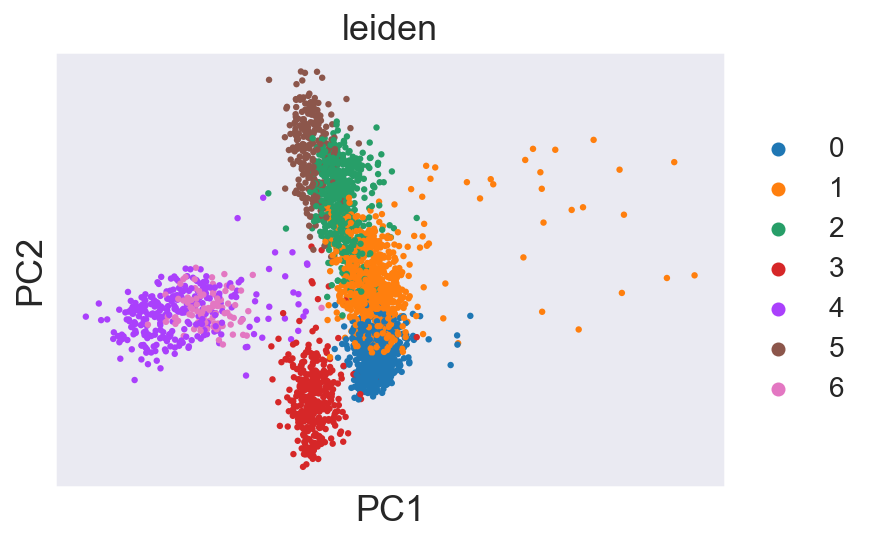

In [165]:
sc.tl.leiden(covid_pbmc, resolution=.7)
sc.pl.pca_scatter(covid_pbmc, color='leiden')

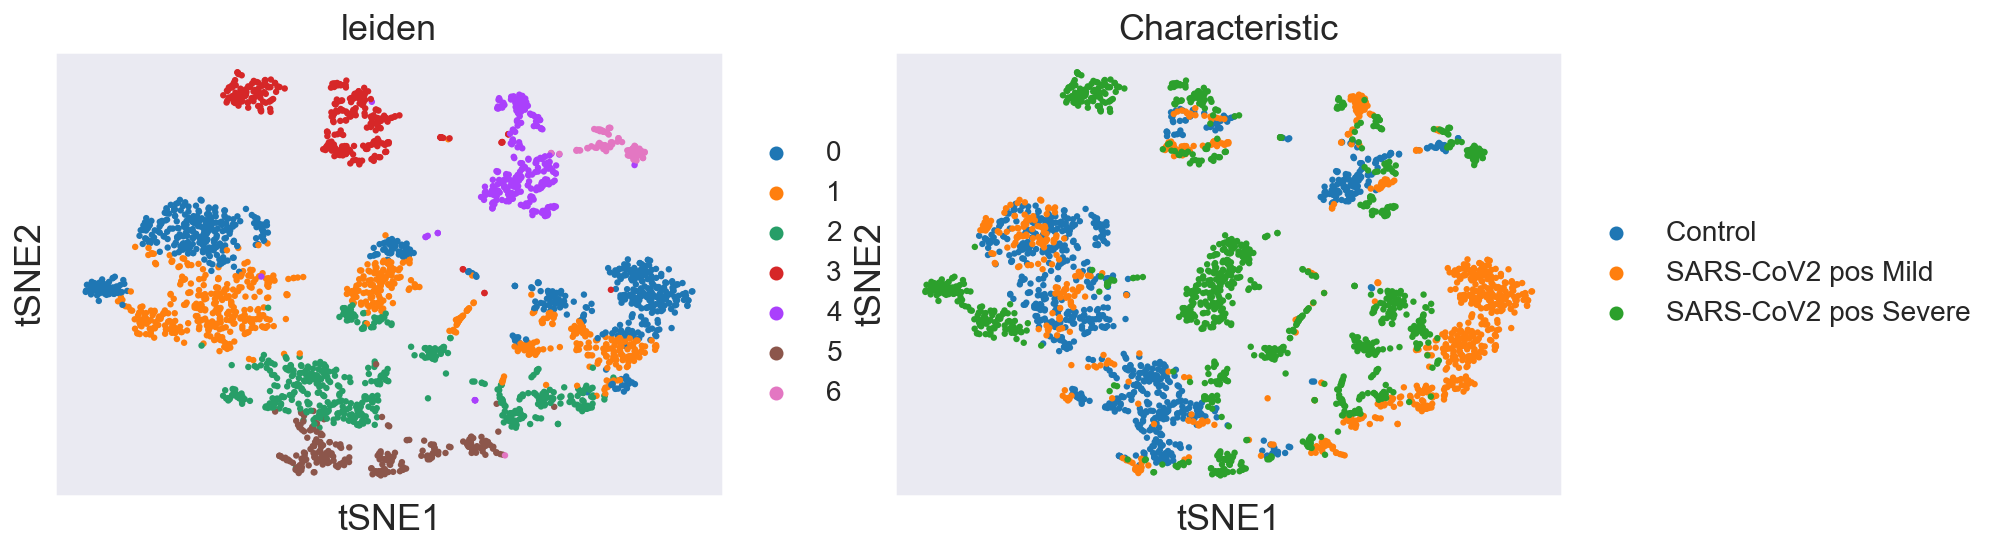

In [167]:
sc.pl.tsne(covid_pbmc, color=['leiden', 'Characteristic'])

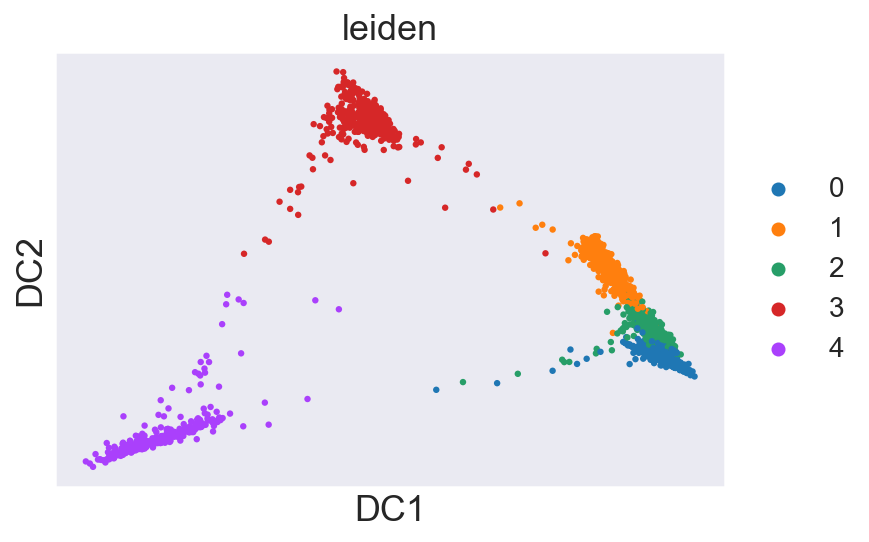

In [161]:
sc.pl.diffmap(covid_pbmc, color='leiden')

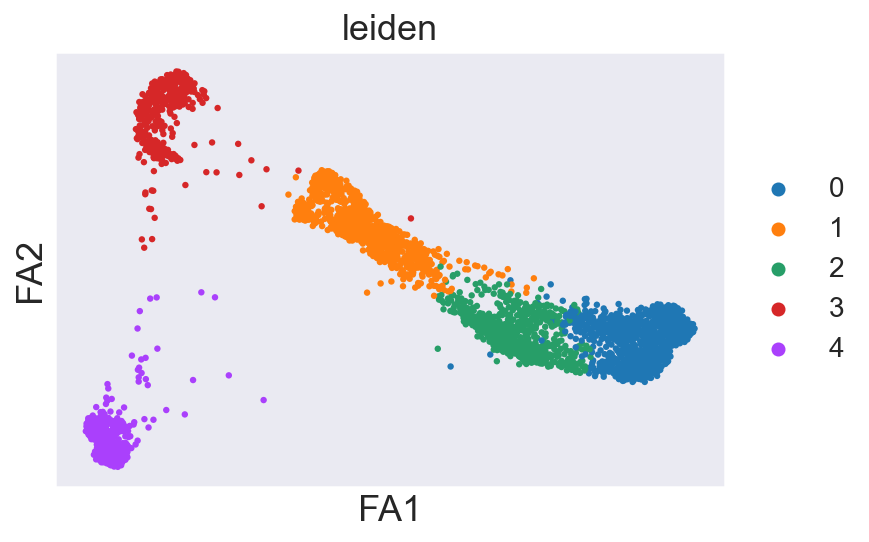

In [162]:
sc.pl.draw_graph(covid_pbmc, color='leiden')

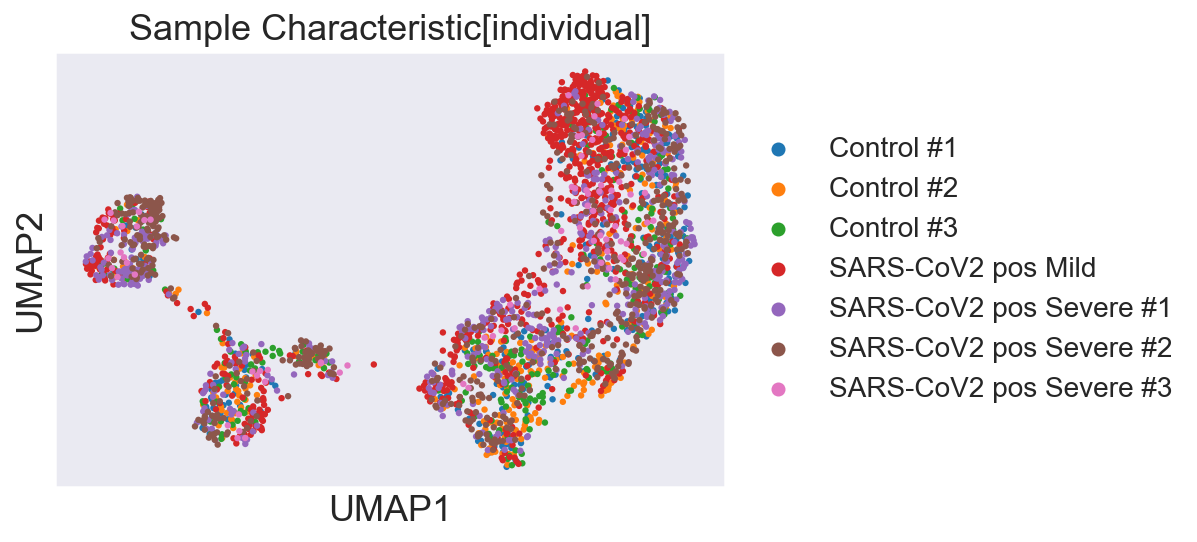

In [163]:
sc.pl.umap(covid_pbmc, color='Sample Characteristic[individual]')

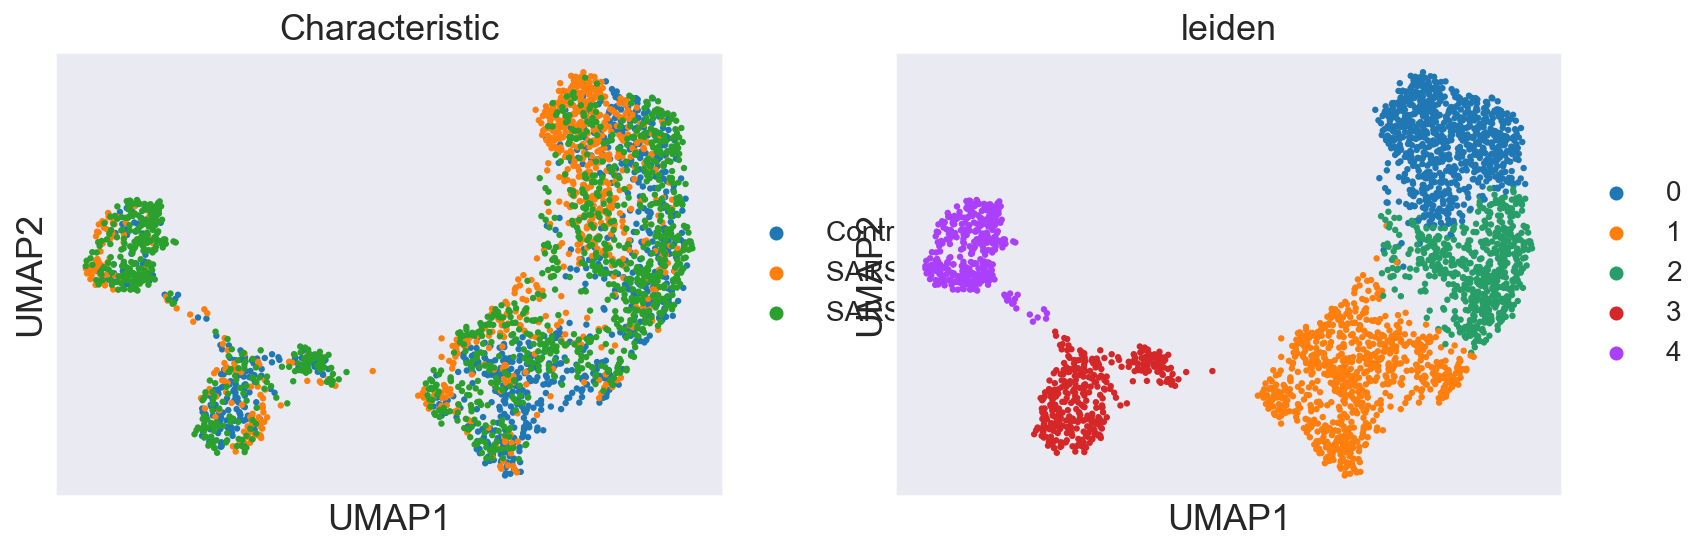

In [164]:
sc.pl.umap(covid_pbmc, color=[ 'Characteristic', 'leiden'])